<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit Webscraping

## Part 4 - Pre-processing & Modelling

## 1. Import
### 1.1 Libraries

In [1]:
import pandas as pd
import string
import re
import numpy as np
import time
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

### 1.2 Cleaned Data

In [2]:
# Import data saved in previous notebook (Part 2)
reddit = pd.read_csv('reddit_cleaned_final.csv')

reddit.head()

,score,total_comments,subreddit,post_type,time_uploaded,title_&_text,title_text_stemmed,title_text_lemmatized,stemmed_round_1,lemmatized_round_1,stemmed_round_2,lemmatized_round_2,stemmed_round_3,lemmatized_round_3
0,1,0,intermittentfasting,new,26/9/23 7:57,Does taking flavoured creatine break a fast Ta...,"['take', 'flavour', 'creatin', 'break', 'fast'...","['taking', 'flavoured', 'creatine', 'break', '...","['take', 'flavour', 'creatin', 'break', 'fast'...","['taking', 'flavoured', 'creatine', 'break', '...","['take', 'flavour', 'creatin', 'break', 'fast'...","['taking', 'flavoured', 'creatine', 'break', '...","['take', 'flavour', 'creatin', 'break', 'fast'...","['taking', 'flavoured', 'creatine', 'break', '..."
1,6,1,intermittentfasting,new,26/9/23 7:46,I lost 120 lbsshe lost 80 One meal a day from ...,"['120', 'lbsshe', '80', 'meal', '']","['120', 'lbsshe', '80', 'meal', '']","['lost', '120', 'lbsshe', 'lost', '80', 'one',...","['lost', '120', 'lbsshe', 'lost', '80', 'one',...","['lost', '120', 'lbsshe', 'lost', '80', 'one',...","['lost', '120', 'lbsshe', 'lost', '80', 'one',...","['lost', '120', 'lbsshe', 'lost', '80', 'one',...","['lost', '120', 'lbsshe', 'lost', '80', 'one',..."
2,0,2,intermittentfasting,new,26/9/23 6:10,Does fasting out of spite work Well see in 4 w...,"['fast', 'spite', 'work', '4', 'week', 'wed', ...","['fasting', 'spite', 'work', '4', 'week', 'wed...","['fast', 'spite', 'see', '4', 'week', 'go', 'w...","['fasting', 'spite', 'see', '4', 'week', 'go',...","['fast', 'spite', 'work', 'see', '4', 'week', ...","['fasting', 'spite', 'work', 'see', '4', 'week...","['fast', 'spite', 'work', 'see', '4', 'week', ...","['fasting', 'spite', 'work', 'see', '4', 'week..."
3,1,0,intermittentfasting,new,26/9/23 6:00,Daily Fasting Checkin Type of fast water juic...,"['daili', 'fast', 'checkin', 'type', 'fast', '...","['daily', 'fasting', 'checkin', 'type', 'fast'...","['daili', 'fast', 'checkin', 'type', 'fast', '...","['daily', 'fasting', 'checkin', 'type', 'fast'...","['daili', 'fast', 'checkin', 'type', 'fast', '...","['daily', 'fasting', 'checkin', 'type', 'fast'...","['daili', 'fast', 'checkin', 'type', 'fast', '...","['daily', 'fasting', 'checkin', 'type', 'fast'..."
4,17,8,intermittentfasting,new,26/9/23 4:10,90 Days of Intermittent Fasting IT WORKS Hi E...,"['90', 'intermitt', 'fast', 'work', 'hi', 'eve...","['90', 'intermittent', 'fasting', 'work', 'hi'...","['90', 'day', 'intermitt', 'fast', 'work', 'hi...","['90', 'day', 'intermittent', 'fasting', 'work...","['90', 'day', 'intermitt', 'fast', 'work', 'hi...","['90', 'day', 'intermittent', 'fasting', 'work...","['90', 'day', 'intermitt', 'fast', 'work', 'hi...","['90', 'day', 'intermittent', 'fasting', 'work..."


## 2. Pre-processing

The pre-processing steps include:
1. Binarizing the two subreddit to be run in the models
2. Train-test split
### 2.1 Binarizing The 2 Classes

In [3]:
# Binarize 'subreddit' for modelling
## 'intermittentfasting' = 0
## 'AnorexiaNervosa' = 1

reddit['subreddit_binarized'] = reddit['subreddit'].map({'intermittentfasting': 0, 'AnorexiaNervosa': 1})

reddit['subreddit_binarized']

0       0
1       0
2       0
3       0
4       0
       ..
3955    1
3956    1
3957    1
3958    1
3959    1
Name: subreddit_binarized, Length: 3960, dtype: int64

**Note:** 3 sets of features are listed to check if the addition of common stopwords/unmeaningful words in each round helps to improve our model performance.

### 2.2 Train-test Split

In [4]:
# Assemble features (x) and target (y)

X_1st_cleaning = reddit['stemmed_round_1'].tolist() # Features obtained from 1st round of cleaning
X_2nd_cleaning = reddit['stemmed_round_2'].tolist() # Features obtained from 2nd round of cleaning
X_final = reddit['stemmed_round_3'].tolist() # Final set of features to be used in modelling
y = reddit['subreddit_binarized'].tolist()

In [5]:
# Train-test split

# 1st round of cleaning
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1st_cleaning, y, test_size=0.2, random_state=42)

# 2nd round of cleaning
X2_train, X2_test, y2_train, y2_test = train_test_split(X_2nd_cleaning, y, test_size=0.2, random_state=42)

# 3rd round of cleaning
X3_train, X3_test, y3_train, y3_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

## 3. Modelling

**Vectorizers used:** <br>
As we need a vectorizer to convert text to numeric form for analysis, we have run each machine learning models with the following 3 vectorization methods:

* **CountVectorizer** (aka N-gram (1,1)) - creates a document-term matrix where the entry of each cell will be a count of the number of times that word occurred in that document.
* **N-gram** - is used to look for groups of adjacent words instead of just looking for single terms. N-gram (2,2) is what we use to find bigrams.
* **TF-IDF** - is basically a count vectorizer that includes some consideration for the length of the document, and also how common the word is across other text messages

### 3.1 Baseline model: Logistic Regression with Count Vectorizer

To achieve the optimal model score, we have gone through:
1. Feature Engineering
2. Comparing Against Other Models

### 3.1.1 Feature Engineering
3 rounds of refining feature selection was carried out by adding more stopwords each time. Using the GridSearchCV function below, the baseline model will be trained using the optimal hyperparameters across 3 different sets of features. The set of features that yielded the highest model score was chosen to be run in the final model.

**GridSearchCV**

To ensure our models are optimised, we will find the best parameters of each model using GridSearchCV and run the models with the optimal hyperparameters. We will first create a function to find the optimal hyperparameters and best score before running it through the 3 sets of data.

In [6]:
# Define a GridSearchCV function to find the optimized model scores 

def grid_search(X_train, y_train):
    
    # Instantiate CountVectorizer
    cv = CountVectorizer()
    X_train_cv = cv.fit_transform(X_train)

    # Apply SMOTE to the train data 
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y_train)

    # Hyperparameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10],  
        'penalty': ['l1', 'l2'],         
        'solver': ['liblinear'],
    }

    # Instantiate a Logistic Regression model
    lr = LogisticRegression()

    # Instantiate GridSearchCV
    gs = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

    # Fit GridSearchCV to data
    gs.fit(X_train_resampled, y_train_resampled)
    
    # Get the best hyperparameters and best score
    best_params = gs.best_params_
    best_score = gs.best_score_
    
    return best_params, best_score


In [7]:
# Apply the grid_search function to the 3 sets of data 
# Get the optimized model score after each round of cleaning

# Create an empty list and store the results for each round
results = []

best_params_1st, best_score_1st = grid_search(X1_train, y1_train)
results.append({'Round': '1st Round', 'Best Parameters': best_params_1st, 'Best Score': best_score_1st})

best_params_2nd, best_score_2nd = grid_search(X2_train, y2_train)
results.append({'Round': '2nd Round', 'Best Parameters': best_params_2nd, 'Best Score': best_score_2nd})

best_params_3rd, best_score_3rd = grid_search(X2_train, y2_train)
results.append({'Round': '3rd Round', 'Best Parameters': best_params_3rd, 'Best Score': best_score_3rd})

# Convert the list of dictionaries to a data frame
clean_progress = pd.concat([pd.DataFrame([r]) for r in results], ignore_index=True)

clean_progress

,Round,Best Parameters,Best Score
0,1st Round,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.920561
1,2nd Round,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.923988
2,3rd Round,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.923988


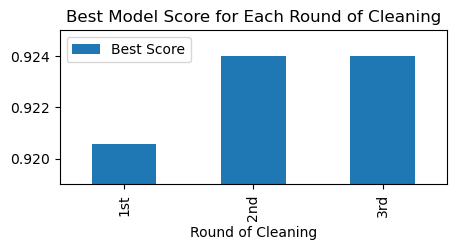

,Round,Best Parameters,Best Score
0,1st Round,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.920561
1,2nd Round,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.923988
2,3rd Round,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.923988


In [8]:
# Chart to visualise model score's progress after rounds of cleaning

clean_progress_graph = clean_progress[['Round', 'Best Score']]
ax = clean_progress_graph.plot(kind='bar', figsize=(5,2))
plt.title('Best Model Score for Each Round of Cleaning', fontsize=12)
plt.xlabel('Round of Cleaning', fontsize=10)
plt.ylim(0.919, 0.925)
new_labels = ['1st', '2nd', '3rd']
ax.set_xticklabels(new_labels)

plt.show()
clean_progress

**Analysis:** 
* The baseline model, Logistic Regression with Count Vectorizer, has an oustanding performance as it consistently achieved scores higher than 0.9 (an industry benchmark). 
* Out of the 3 sets of features, the 2nd set which yielded the highest score would be used in the final modelling.

**Note:** The list of custom stopwords added in the 2nd set include:<br>
['tri', 'right', 'year', 'around', 'cant', 'start', 'alway', 'end', 'hope', 'thank', 'didnt', 'gain', 'could', 'ago', 'without', 'stop', 'work', 'post', 'life', 'get', 'long', 'use', 'love', 'normal', 'say', 'week', 'past', 'comment', 'thing', 'lose', 'everyon', 'look', 'sure', 'thought', 'littl', 'peopl', 'never', 'meal', 'els', 'find', 'time', 'come', 'went', 'make', 'anyth', 'pretti', 'felt', 'almost', 'period', 'ill', 'hard', 'advic', 'notic', 'two', 'want', 'made', 'id', 'healthi', 'actual']

## 3.1.2 Comparing Against Other Models

In this section, we compared our baseline model with other models to find the model with the best score.

We have evaluated **9 models** in total and they were:

    1. Logistic Regression with CountVectorizer (Baseline model)
    2. Multinomial Naive Bayes with CountVectorizer 
    3. XGBoost Classifier with CountVectorizer
    4. Logistic Regression with N-gram (2,2)
    5. Multinomial Naive Bayes with N-gram (2,2)
    6. XGBoost Classifier with N-gram (2,2)
    7. Logistic Regression with TF-IDF
    8. Multinomial Naive Bayes with TF-IDF 
    9. XGBoost Classifier with TF-IDF
    
**Note:**
* **Logistic Regression model**: A statistical model used for binary classification, predicting one of two possible outcomes based on input features.
* **Multinomial Naive Bayes model**: A probabilistic classification model often used for text classification, which assumes that features are conditionally independent and predicts multiple discrete classes.
* **XGBoost model**: An ensemble machine learning model that boosts the performance of decision trees, often used for regression and classification tasks, known for its efficiency and accuracy.
    
**Model Performance Criteria:** <br>
The models' performance would be illustrated by the following metrics after applying GridSearchCV:
   * Accuracy (train data)
   * Accuracy (test data)
   * Precision (test data)
   * Recall (test data)
   * F1 (test data)
   * ROC (test data)

We evaluated their performance **mainly based on the accuracy (test) scores**, whilst also checking against the other metrics to for greater reliability. Finally, we also compared the execution time to ensure that performance was not improved at the expense of longer execution time.


### 3.1.2.1 Logistic Regression with CountVectorizer

In [9]:
# Find scores

# Instantiate CountVectorizer 
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X2_train)
X_test_cv = cv.transform(X2_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the Logistic Regression model
lr = LogisticRegression(C=1, penalty='l1', solver='liblinear') #based on the hyperparameters above
            
# Fit the model
lr.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both training and test data
y_pred_train = lr.predict(X_train_resampled)
y_pred_test = lr.predict(X_test_cv)
            
# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

lr_cv = pd.DataFrame({'Model': ['Logistic Regression'], 
                      'Vectorizer': ['Count Vectorizer'],
                      'Accuracy (Train)': [accuracy_train],
                      'Accuracy (Test)': [accuracy_test],
                      'Precision (Test)': [precision_test],
                      'Recall (Test)': [recall_test],
                      'F1 (Test)': [f1_test],
                      'ROC (Test)': [roc_test], 
                      'Execution Time (ms)': [exec_time]})
lr_cv.set_index('Model', inplace=True)

lr_cv

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Logistic Regression,Count Vectorizer,0.964486,0.924242,0.939058,0.899204,0.918699,0.923096,10.328054


### 3.1.2.2 Multinomial NB with CountVectorizer

In [10]:
# Find best hyperparameters

# Instantiate CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y2_train)

# Instantiate the Multinomial NB model
multi = MultinomialNB()

# Hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Instantiate GridSearchCV
gs_multi = GridSearchCV(estimator=multi, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_multi.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_multi_cv = gs_multi.best_params_
best_score_multi_cv = gs_multi.best_score_
    
print(f'Best hyperparameters: {best_params_multi_cv}')
print(f'Best score: {best_score_multi_cv:.2f}')


Best hyperparameters: {'alpha': 0.5, 'fit_prior': True}
Best score: 0.94


In [11]:
# Find scores

# Instantiate CountVectorizer 
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X2_train)
X_test_cv = cv.transform(X2_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the Multinomial NB model
multi = MultinomialNB()
multi.set_params(**best_params_multi_cv)
            
# Fit the model
multi.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both training and test data
y_pred_train = multi.predict(X_train_resampled)
y_pred_test = multi.predict(X_test_cv)
            
# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

multi_cv = pd.DataFrame({'Model': ['Multinomial NB'], 
                         'Vectorizer': ['Count Vectorizer'],
                         'Accuracy (Train)': [accuracy_train],
                         'Accuracy (Test)': [accuracy_test],
                         'Precision (Test)': [precision_test],
                         'Recall (Test)': [recall_test],
                         'F1 (Test)': [f1_test],
                         'ROC (Test)': [roc_test],
                         'Execution Time (ms)': [exec_time]})

multi_cv.set_index('Model', inplace=True)

multi_cv

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Multinomial NB,Count Vectorizer,0.961994,0.945707,0.948925,0.93634,0.94259,0.945278,0.955105


### 3.1.2.3 XGBoost with Count Vectorizer

In [12]:
# Find best hyperparameters

# Instantiate CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y2_train)

# Instantiate an XGBoost model
xgb = XGBClassifier(random_state=42)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_xgb.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_xgb_cv = gs_xgb.best_params_
best_score_xgb_cv = gs_xgb.best_score_
    
print(f'Best hyperparameters: {best_params_xgb_cv}')
print(f'Best score: {best_score_xgb_cv:.2f}')

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score: 0.92


In [13]:
# Find scores

# Instantiate CountVectorizer 
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X2_train)
X_test_cv = cv.transform(X2_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_cv, y2_train)

# Start of execution
start_time = time.time()

# Instantiate an XGBoost model
xgb = XGBClassifier(random_state=42)
            
# Fit the model
xgb.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both training and test data
y_pred_train = xgb.predict(X_train_resampled)
y_pred_test = xgb.predict(X_test_cv)
            
# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

xgb_cv = pd.DataFrame({'Model': ['XGBoost'], 
                      'Vectorizer': ['Count Vectorizer'],
                      'Accuracy (Train)': [accuracy_train],
                      'Accuracy (Test)': [accuracy_test],
                      'Precision (Test)': [precision_test],
                      'Recall (Test)': [recall_test],
                      'F1 (Test)': [f1_test],
                      'ROC (Test)': [roc_test],
                      'Execution Time (ms)': [exec_time]})
xgb_cv.set_index('Model', inplace=True)

xgb_cv

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
XGBoost,Count Vectorizer,0.972897,0.938131,0.92268,0.949602,0.935948,0.938656,165.045023


### 3.1.2.4 Logistic Regression with N-gram (2,2)

In [14]:
# Find best hyperparameters

# Instantiate CountVectorizer
ngram = CountVectorizer(ngram_range=(2,2))
X_train_ngram = cv.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ngram, y2_train)

# Instantiate the Multinomial NB model
lr = LogisticRegression()

# Hyperparameter grid
param_grid = param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
                           'penalty': ['l1', 'l2'],   
                           'solver': ['liblinear']
                          }

# Instantiate GridSearchCV
gs_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_lr.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_lr_ngram = gs_lr.best_params_
best_score_lr_ngram = gs_lr.best_score_
    
print(f'Best hyperparameters: {best_params_lr_ngram}')
print(f'Best score: {best_score_lr_ngram:.2f}')


Best hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.92


In [15]:
# Find scores

# Instantiate CountVectorizer 
ngram = CountVectorizer(ngram_range=(2,2))
X_train_ngram = ngram.fit_transform(X2_train)
X_test_ngram = ngram.transform(X2_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ngram, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the Multinomial NB model
lr = LogisticRegression()
lr.set_params(**best_params_lr_ngram)
            
# Fit the model
lr.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both training and test data
y_pred_train = lr.predict(X_train_resampled)
y_pred_test = lr.predict(X_test_ngram)
            
# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

lr_ngram = pd.DataFrame({'Model': ['Logistic Regression'], 
                         'Vectorizer': ['N-gram (2,2)'],
                         'Accuracy (Train)': [accuracy_train],
                         'Accuracy (Test)': [accuracy_test],
                         'Precision (Test)': [precision_test],
                         'Recall (Test)': [recall_test],
                         'F1 (Test)': [f1_test],
                         'ROC (Test)': [roc_test],
                         'Execution Time (ms)': [exec_time]})

lr_ngram.set_index('Model', inplace=True)

lr_ngram

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Logistic Regression,"N-gram (2,2)",0.936449,0.810606,0.925094,0.655172,0.767081,0.80349,49.114227


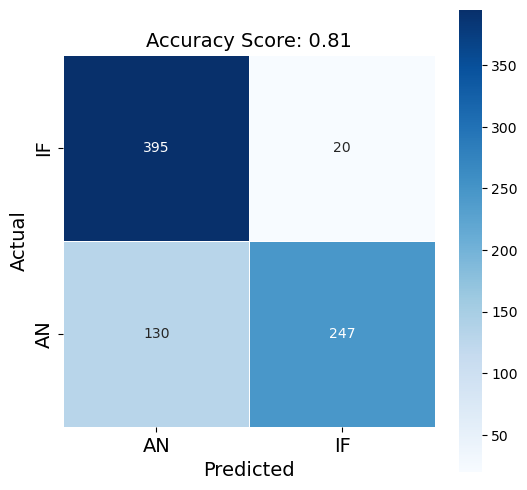

In [16]:
# Generate confusion matrix
cm = confusion_matrix(y2_test, y_pred_test)

# Calculate accuracy score (you need to compute it)
score = accuracy_score(y2_test, y_pred_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues',
            xticklabels = ['AN', 'IF'],
            yticklabels = ['IF', 'AN'])
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Accuracy Score: {:.2f}'.format(score), size=14)
plt.tick_params(labelsize=14)
plt.show()


### 3.1.2.5 Multinomial NB with N-gram (2,2)

In [17]:
# Find best hyperparameters

# Instantiate CountVectorizer
ngram = CountVectorizer(ngram_range=(2,2))
X_train_ngram = cv.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ngram, y2_train)

# Instantiate the Multinomial NB model
multi = MultinomialNB()

# Hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'fit_prior': [True, False]
}

# Instantiate GridSearchCV
gs_multi = GridSearchCV(estimator=multi, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_multi.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_multi_ngram = gs_multi.best_params_
best_score_multi_ngram = gs_multi.best_score_
    
print(f'Best hyperparameters: {best_params_multi_ngram}')
print(f'Best score: {best_score_multi_ngram:.2f}')


Best hyperparameters: {'alpha': 0.5, 'fit_prior': True}
Best score: 0.94


In [18]:
# Find scores

# Instantiate CountVectorizer 
ngram = CountVectorizer(ngram_range=(2,2))
X_train_ngram = ngram.fit_transform(X2_train)
X_test_ngram = ngram.transform(X2_test)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ngram, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the Multinomial NB model
multi = MultinomialNB()
multi.set_params(**best_params_multi_ngram)
            
# Fit the model
multi.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both training and test data
y_pred_train = multi.predict(X_train_resampled)
y_pred_test = multi.predict(X_test_ngram)
            
# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

multi_ngram = pd.DataFrame({'Model': ['Multinomial NB'], 
                         'Vectorizer': ['N-gram (2,2)'],
                         'Accuracy (Train)': [accuracy_train],
                         'Accuracy (Test)': [accuracy_test],
                         'Precision (Test)': [precision_test],
                         'Recall (Test)': [recall_test],
                         'F1 (Test)': [f1_test],
                         'ROC (Test)': [roc_test],
                         'Execution Time (ms)': [exec_time]})

multi_ngram.set_index('Model', inplace=True)

multi_ngram

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Multinomial NB,"N-gram (2,2)",0.981308,0.897727,0.897849,0.885942,0.891856,0.897188,1.876116


### 3.1.2.6 XGBoost with N-gram (2,2)

In [19]:
# Find best hyperparameters

# Instantiate CountVectorizer
ngram = CountVectorizer(ngram_range=(2,2))
X_train_xgb = cv.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ngram, y2_train)

# Instantiate an XGBoost model
xgb = XGBClassifier(random_state=42)

# Hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 4, 5],
              'learning_rate': [0.001, 0.01, 0.1]
             }

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_xgb.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_xgb_ngram = gs_xgb.best_params_
best_score_xgb_ngram = gs_xgb.best_score_
    
print(f'Best hyperparameters: {best_params_xgb_ngram}')
print(f'Best score: {best_score_xgb_ngram:.2f}')

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300}
Best score: 0.77


In [20]:
# Find scores

# Instantiate CountVectorizer 
ngram = CountVectorizer(ngram_range=(2,2))
X_train_ngram = ngram.fit_transform(X2_train)
X_test_ngram = ngram.transform(X2_test)

# Apply SMOTE to the train data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_ngram, y2_train)

# Start of execution
start_time = time.time()

# Instantiate an XGBoost model
xgb = XGBClassifier(random_state=42)
            
# Fit the model
xgb.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both training and test data
y_pred_train = xgb.predict(X_train_resampled)
y_pred_test = xgb.predict(X_test_ngram)
            
# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

xgb_ngram = pd.DataFrame({'Model': ['XGBoost'], 
                      'Vectorizer': ['N-gram (2,2)'],
                      'Accuracy (Train)': [accuracy_train],
                      'Accuracy (Test)': [accuracy_test],
                      'Precision (Test)': [precision_test],
                      'Recall (Test)': [recall_test],
                      'F1 (Test)': [f1_test],
                      'ROC (Test)': [roc_test],
                      'Execution Time (ms)': [exec_time]})
xgb_ngram.set_index('Model', inplace=True)

xgb_ngram

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
XGBoost,"N-gram (2,2)",0.850779,0.786616,0.882353,0.636605,0.739599,0.779748,810.106993


### 3.1.2.7 Logistic Regression with TF-IDF

In [21]:
# Find best hyperparameters

# Instantiate CountVectorizer
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y2_train)

# Instantiate the Multinomial NB model
lr = LogisticRegression()

# Hyperparameter grid
param_grid = param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 
                           'penalty': ['l1', 'l2'],   
                           'solver': ['liblinear']
                          }

# Instantiate GridSearchCV
gs_lr = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_lr.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_lr_tf = gs_lr.best_params_
best_score_lr_tf = gs_lr.best_score_
    
print(f'Best hyperparameters: {best_params_lr_tf}')
print(f'Best score: {best_score_lr_tf:.2f}')


Best hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.94


In [22]:
# Find scores

# Instantiate Count Vectorizer 
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X2_train)
X_test_tf = tf.transform(X2_test)

# Apply SMOTE to the train data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the Logistic Regression model
lr = LogisticRegression()
lr.set_params(**best_params_lr_tf)
            
# Fit the model
lr.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both train and test data
y_pred_train = lr.predict(X_train_resampled)
y_pred_test = lr.predict(X_test_tf)

# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

lr_tfidf = pd.DataFrame({'Model': ['Logistic Regression'], 
                         'Vectorizer': ['TF-IDF'],
                         'Accuracy (Train)': [accuracy_train],
                         'Accuracy (Test)': [accuracy_test],
                         'Precision (Test)': [precision_test],
                         'Recall (Test)': [recall_test],
                         'F1 (Test)': [f1_test],
                         'ROC (Test)': [roc_test],
                         'Execution Time (ms)': [exec_time]})

lr_tfidf.set_index('Model', inplace=True)

lr_tfidf

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Logistic Regression,TF-IDF,0.993458,0.926768,0.932249,0.912467,0.922252,0.926113,9.712934


### 3.1.2.8 Multinomial NB with TF-IDF

In [23]:
# Find best hyperparameters

# Instantiate CountVectorizer
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y2_train)

# Instantiate the Multinomial NB model
multi = MultinomialNB()

# Hyperparameter grid
param_grid = {'alpha': [0.1, 0.5, 1.0],
              'fit_prior': [True, False]}

# Instantiate GridSearchCV
gs_multi = GridSearchCV(estimator=multi, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_multi.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_multi_tf = gs_multi.best_params_
best_score_multi_tf = gs_multi.best_score_
    
print(f'Best hyperparameters: {best_params_multi_tf}')
print(f'Best score: {best_score_multi_tf:.2f}')


Best hyperparameters: {'alpha': 0.5, 'fit_prior': True}
Best score: 0.93


In [24]:
# Find scores

# Instantiate Count Vectorizer 
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X2_train)
X_test_tf = tf.transform(X2_test)

# Apply SMOTE to the train data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the Multinomial NB model
multi = MultinomialNB()
multi.set_params(**best_params_multi_tf)
            
# Fit the model
multi.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both train and test data
y_pred_train = multi.predict(X_train_resampled)
y_pred_test = multi.predict(X_test_tf)

# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

multi_tfidf = pd.DataFrame({'Model': ['Multinomial NB'], 
                         'Vectorizer': ['TF-IDF'],
                         'Accuracy (Train)': [accuracy_train],
                         'Accuracy (Test)': [accuracy_test],
                         'Precision (Test)': [precision_test],
                         'Recall (Test)': [recall_test],
                         'F1 (Test)': [f1_test],
                         'ROC (Test)': [roc_test],
                         'Execution Time (ms)': [exec_time]})

multi_tfidf.set_index('Model', inplace=True)

multi_tfidf

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Multinomial NB,TF-IDF,0.964798,0.929293,0.914729,0.938992,0.926702,0.929737,1.034975


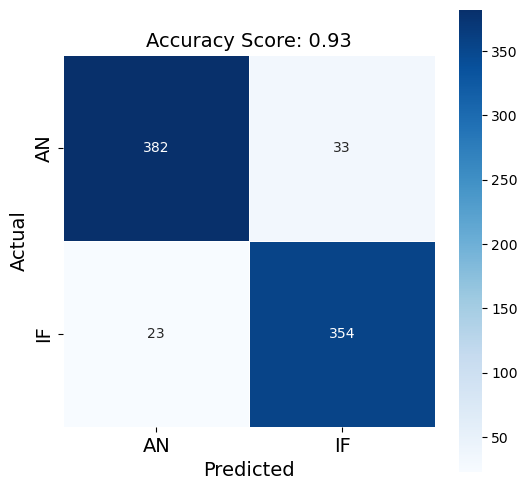

In [25]:
# Generate confusion matrix
cm = confusion_matrix(y2_test, y_pred_test)

# Calculate accuracy score (you need to compute it)
score = accuracy_score(y2_test, y_pred_test)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues', 
            xticklabels = ['AN', 'IF'],
            yticklabels = ['AN', 'IF'])
plt.ylabel('Actual', fontsize=14)
plt.xlabel('Predicted', fontsize=14)
plt.title('Accuracy Score: {:.2f}'.format(score), size=14)
plt.tick_params(labelsize=14)
plt.show()


### 3.1.2.9 XGBoost with TF-IDF

In [26]:
# Find best hyperparameters

# Instantiate CountVectorizer
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X2_train)

# Apply SMOTE to the train data 
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y2_train)

# Instantiate the Multinomial NB model
xgb = XGBClassifier()

# Hyperparameter grid
param_grid = {'n_estimators': [100, 200, 300],
              'max_depth': [3, 4, 5],
              'learning_rate': [0.001, 0.01, 0.1]
             }

# Instantiate GridSearchCV
gs_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to data
gs_xgb.fit(X_train_resampled, y_train_resampled)
    
# Get the best hyperparameters and best score
best_params_xgb_tf = gs_xgb.best_params_
best_score_xgb_tf = gs_xgb.best_score_
    
print(f'Best hyperparameters: {best_params_xgb_tf}')
print(f'Best score: {best_score_xgb_tf:.2f}')


Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300}
Best score: 0.92


In [27]:
# Find scores

# Instantiate Count Vectorizer 
tf = TfidfVectorizer()
X_train_tf = tf.fit_transform(X2_train)
X_test_tf = tf.transform(X2_test)

# Apply SMOTE to the train data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tf, y2_train)

# Start of execution
start_time = time.time()

# Instantiate the XGBooster model
xgb = XGBClassifier()
            
# Fit the model
xgb.fit(X_train_resampled, y_train_resampled)

# Find execution time
end_time = time.time()
exec_time = (end_time - start_time) * 1000
            
# Make predictions on both train and test data
y_pred_train = xgb.predict(X_train_resampled)
y_pred_test = xgb.predict(X_test_tf)

# Accuracy (train)
accuracy_train = accuracy_score(y_train_resampled, y_pred_train)

# Accuracy (test)
accuracy_test = accuracy_score(y2_test, y_pred_test)
            
# Precision (test)
precision_test = precision_score(y2_test, y_pred_test, average='binary')
            
# Recall (test)
recall_test = recall_score(y2_test, y_pred_test, average='binary')
            
# F1 (test)
f1_test = f1_score(y2_test, y_pred_test, average='binary')
            
# ROC (test)
roc_test = roc_auc_score(y2_test, y_pred_test)

xgb_tfidf = pd.DataFrame({'Model': ['XGBoost'], 
                         'Vectorizer': ['TF-IDF'],
                         'Accuracy (Train)': [accuracy_train],
                         'Accuracy (Test)': [accuracy_test],
                         'Precision (Test)': [precision_test],
                         'Recall (Test)': [recall_test],
                         'F1 (Test)': [f1_test],
                         'ROC (Test)': [roc_test],
                         'Execution Time (ms)': [exec_time]})

xgb_tfidf.set_index('Model', inplace=True)

xgb_tfidf

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
XGBoost,TF-IDF,0.978816,0.929293,0.914729,0.938992,0.926702,0.929737,794.212103


### 3.1.3 Summary of model performance

In [31]:
overall_results = pd.concat([lr_cv, multi_cv, xgb_cv, lr_ngram, multi_ngram, xgb_ngram, lr_tfidf, multi_tfidf, xgb_tfidf])
overall_results.sort_values(by='Accuracy (Test)', ascending=False)

,Vectorizer,Accuracy (Train),Accuracy (Test),Precision (Test),Recall (Test),F1 (Test),ROC (Test),Execution Time (ms)
Model,,,,,,,,
Multinomial NB,Count Vectorizer,0.961994,0.945707,0.948925,0.936340,0.942590,0.945278,0.955105
XGBoost,Count Vectorizer,0.972897,0.938131,0.922680,0.949602,0.935948,0.938656,165.045023
Multinomial NB,TF-IDF,0.964798,0.929293,0.914729,0.938992,0.926702,0.929737,1.034975
XGBoost,TF-IDF,0.978816,0.929293,0.914729,0.938992,0.926702,0.929737,794.212103
Logistic Regression,TF-IDF,0.993458,0.926768,0.932249,0.912467,0.922252,0.926113,9.712934
Logistic Regression,Count Vectorizer,0.964486,0.924242,0.939058,0.899204,0.918699,0.923096,10.328054
Multinomial NB,"N-gram (2,2)",0.981308,0.897727,0.897849,0.885942,0.891856,0.897188,1.876116
Logistic Regression,"N-gram (2,2)",0.936449,0.810606,0.925094,0.655172,0.767081,0.803490,49.114227
XGBoost,"N-gram (2,2)",0.850779,0.786616,0.882353,0.636605,0.739599,0.779748,810.106993


**Multinomial NB (with Count Vectorizer)** is our final chosen model as it has the **highest mean accuracy**, **consistently high scores across all metrics (0.90<)**, and **fastest execution time**.

## 4. Conclusion
### 4.1 Summary
* The 2nd set of features were chosen given its best model score compared with the other two rounds of feature engineering.
* All the XGBoost models had very long execution times due to their nature of sequential prediction of decision trees. This model should not be considered in this use case in the future to prevent inefficiency.
* Despite a stellar performance, our baseline model, Logistic Regression with Count Vectorizer, was outperformed by Multinomial NB with Count Vectorizer in all test scores. This likely attributed to how Multinomial NB is:
    - well-suited for **text classification tasks**
    - makes a **"naive" assumption that features (i.e. words/tokens) are conditionally independent** given the class label, especially if there are strong keyword associations between the 2 classes
    - designed for **categorical data**, which can be a better fit when dealing with text data where each word or token can be treated as a category

### 4.2 Recommendations
* As people who practise intermittent fasting might end up binging after breaking fast, it is recommended that the application explores the other spectrum of eating disorder as well.
* With little information on the demographics of the intermittent fasting and anorexia communities, our application can help to explore these parameters based on the user profile information and develop more targeted solutions to address anorexia.
